## KMeans Image Segmentation

This code reads an image and treats pixel as three element feature vector of unsupervised data. It performs KMeans clustering of the pixels and then re-colours the image using the median of each colour component within the clusters.

In [25]:
# The usual loading of modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
from sklearn import cluster
from scipy import misc
from numpy import zeros
import numpy as np
import math
import warnings
import copy
import sys

(3573360, 3)


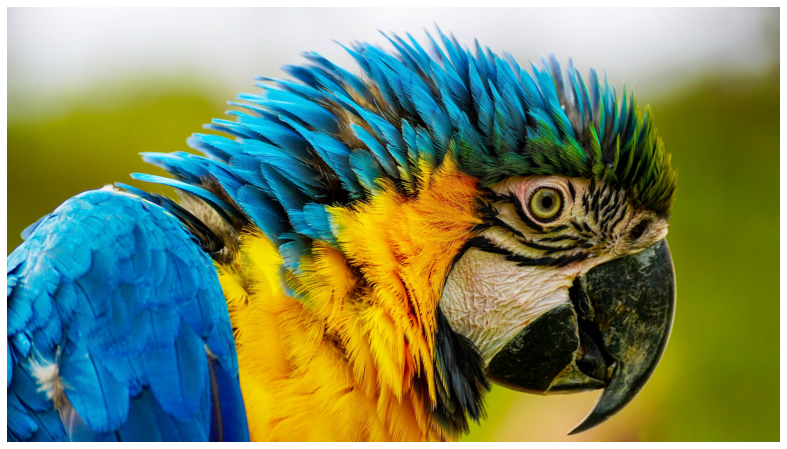

In [26]:
# Load an image.
imagex = image.imread("parrot.jpeg") # You may want to test with a smaller image, it will be faster
plt.figure(figsize = (15,8))
plt.axis("off") # An axis free plot
plt.imshow(imagex) # Display the image
x, y, z = imagex.shape # Get the dimensions of the image (z is the number of colour bytes)
image_2d = imagex.reshape(x*y, z) # Turn the 2D pixels into 1D pixels
image_2dr = zeros([x*y,z]) # and create an output array for the re-coloured image. 
print(image_2d.shape)

In [27]:
class K_Means:

    def __init__(self, n_clusters=5, tolerance=0.0001, max_iter=500):
        self._max_iter = max_iter
        self.tolerance = tolerance
        self._clusters = n_clusters
        self.cluster_centers = []
        self.labels2 = []
        self.labels = {}
        
    # https://gist.github.com/mmmayo13/3d5c2b12218dfd79acc27c64b3b7dd86
    def _naive_sharding(self, dataset, clusters):

        def _get_mean(sums, step):
            return sums / step

        m, n = np.shape(dataset)

        composite = np.mat(np.sum(dataset, axis=1))
        dataset = np.append(composite.T, dataset, axis=1)
        dataset.sort(axis=0)

        step = int(np.floor(m / clusters))
        vfunc = np.vectorize(_get_mean)

        for x in range(clusters):
            if x == clusters - 1:
                self.cluster_centers.append(vfunc(np.sum(dataset[x * step:, 1:], axis=0), step))
            else:
                self.cluster_centers.append(vfunc(np.sum(dataset[x * step:(x + 1) * step, 1:], axis=0), step))

    def fit(self, dataset):

        self._naive_sharding(dataset, self._clusters)


        for _ in range(self._max_iter):
            self.labels2 = []
            self.labels = {classification: [] for classification in range(self._clusters)}

            for feature in dataset:
                distances = [self._euclid_distance(feature, c_cluster) for c_cluster in
                             self.cluster_centers if not np.all(c_cluster == feature)]

                classification = distances.index(min(distances))
                self.labels2.append(classification)
                self.labels[classification].append(feature)

            prev = copy.deepcopy(self.cluster_centers)

            self._recompute_clusters()

            is_opt = True

            for j in range(len(self.cluster_centers)):
                original_c_cluster = prev[j]
                curr = self.cluster_centers[j]
                
                if np.sum(((curr - original_c_cluster) / original_c_cluster) * 100.0) > self.tolerance:
                    is_opt = False
            if is_opt:
                break

    def _recompute_clusters(self):
        for key, item in self.labels.items():
            i = 0
            sum_1 = 0
            sum_2 = 0
            sum_3 = 0

            for x in range(len(item)):
                sum_1 += item[x][0]
                sum_2 += item[x][1]
                sum_3 += item[x][2]
                i += 1
            self.cluster_centers[key] = np.squeeze(np.asarray(self.cluster_centers[key]))
            self.cluster_centers[key][0] = sum_1 / i
            self.cluster_centers[key][1] = sum_2 / i
            self.cluster_centers[key][2] = sum_3 / i

    def _euclid_distance(self, feature, c_cluster):

        return np.linalg.norm(c_cluster - feature)

In [28]:
# THIS IS THE PART YOU ARE TO REPLACE

cluster_count = 5
kmeans_cluster = K_Means(n_clusters=cluster_count)
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers
cluster_labels = kmeans_cluster.labels2


In [29]:
# Turn the clustered data into a DataFrame and add the class as a fourth column
cluster_2d = pd.DataFrame(image_2d, columns=list('abc'))
cluster_2d['d'] = cluster_labels
print(cluster_2d)

# loop over each of the clusters and calculate a colour to represent it.
for a in range(0,cluster_count):   
    subset = cluster_2d.loc[cluster_2d['d'] == a] # Extract all the pixels that belong to the cluster
    m = subset.median().values # and calcuate the median of each colour channel
    print(m) # Show each of the colours we're going to use
    
    # Each pixel in the cluster is then painted with the cluster colour
    for i in range(0, len(cluster_labels)):
        if (cluster_labels[i] == a):
            image_2dr[i] = m[0:3]

           a    b    c  d
0        216  217  222  4
1        216  217  222  4
2        216  217  222  4
3        217  218  223  4
4        217  218  223  4
...      ...  ...  ... ..
3573355  105  118    0  1
3573356  103  116    0  1
3573357  102  115    0  1
3573358  104  117    0  1
3573359  107  120    2  1

[3573360 rows x 4 columns]
[17. 29. 14.  0.]
[105. 111.   2.   1.]
[213. 165.   5.   2.]
[  3. 121. 180.   3.]
[219. 222. 228.   4.]


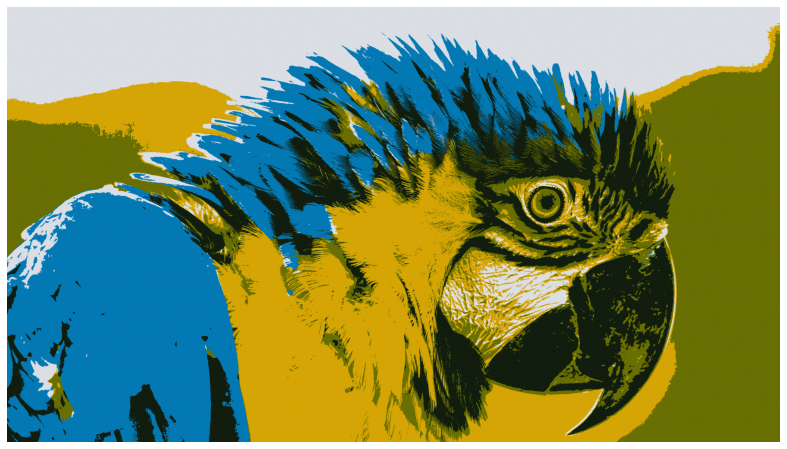

In [30]:
# Display the results
image_out = image_2dr.reshape(x, y, z)/255.0 #Scale to 0-1 range
plt.figure(figsize = (15,8))
plt.axis("off")
plt.imshow(image_out)

# Use the following to save the image
plt.savefig('clustered_out.png', bbox_inches='tight')